In [76]:
import torch
import torchvision.models as models, torch.optim as optim
import torchvision.transforms as transforms

from torch.cuda.amp import autocast, GradScaler
import torch.nn as nn
import copy
import os, io
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn import CrossEntropyLoss

from sklearn.model_selection import train_test_split

import gdown
from tqdm import tqdm, trange
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np, pandas as pd
#from torchmetrics import TotalVariation as TV
import random
from google.colab import files 

import time
import albumentations as albu
import cv2
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [54]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [77]:
import gc

def cleanup():
    gc.collect()
    torch.cuda.empty_cache()
    
cleanup()

In [78]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)

set_seed(42)

In [79]:
resnet = models.resnet50(pretrained=True)

# Remove last two layers
modules = list(resnet.children())[:-2]
resnet = nn.Sequential(*modules)

# Define segmentation head
segmentation_head = nn.Sequential(
    nn.ConvTranspose2d(2048, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.ConvTranspose2d(64, 19, kernel_size=2, stride=2, padding=0)
)

# Combine ResNet50 and segmentation head
model = nn.Sequential(resnet, segmentation_head)

# Test with a dummy input
x = torch.randn(1, 3, 512,  512)
output = model(x)
print(output.shape) # should print (1, 19, 512, 512)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1, 19, 512, 512])


In [80]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((512, 512)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [81]:
label_list = {'0': 'background', 1: 'skin', 2: 'nose', 3: 'eye_g', 4: 'l_eye',
                  '5': 'r_eye', '6': 'l_brow', 7: 'r_brow', 8: 'l_ear', 9: 'r_ear',
                  '10': 'mouth',	11: 'u_lip', 12: 'l_lip',	13: 'hair',
                  '14': 'hat', 15: 'ear_r',	16: 'neck_l',	17: 'neck', 18: 'cloth'}


label_dict = {v: k for k, v in label_list.items()}
n_classes = len(label_dict)
n_classes

19

In [82]:
!unzip  /content/drive/MyDrive/img_test.zip 

Archive:  /content/drive/MyDrive/img_test.zip
replace img_test/7858.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [83]:
!unzip  /content/drive/MyDrive/img_train.zip 

Archive:  /content/drive/MyDrive/img_train.zip
replace img_train/7730.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [84]:
!unzip  /content/drive/MyDrive/CelebAMask-HQ-mask-color-train.zip 

Archive:  /content/drive/MyDrive/CelebAMask-HQ-mask-color-train.zip
replace content/CelebAMask-HQ/CelebAMask-HQ-mask-color-train/23500.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [85]:
!unzip  /content/drive/MyDrive/CelebAMask-HQ-mask-test.zip 

Archive:  /content/drive/MyDrive/CelebAMask-HQ-mask-test.zip
replace content/CelebAMask-HQ/CelebAMask-HQ-mask-test/20192.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [86]:
!unzip  /content/drive/MyDrive/CelebAMask-HQ-mask-color-test.zip 

Archive:  /content/drive/MyDrive/CelebAMask-HQ-mask-color-test.zip
replace content/CelebAMask-HQ/CelebAMask-HQ-mask-color-test/20192.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [87]:
!unzip /content/drive/MyDrive/CelebAMask-HQ-mask-train.zip 

Archive:  /content/drive/MyDrive/CelebAMask-HQ-mask-train.zip
replace content/CelebAMask-HQ/CelebAMask-HQ-mask-train/23500.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [88]:
from google.colab import files
uploaded = files.upload()
celeb_train_test_split = pd.read_csv(io.BytesIO(uploaded['celeb_train_test_split.csv'])) 

Saving celeb_train_test_split.csv to celeb_train_test_split (2).csv


In [89]:
df_train_ind, df_test_ind = pd.DataFrame(), pd.DataFrame()
df_train_ind['id'] = celeb_train_test_split[celeb_train_test_split['is_train'] == True]['name']
df_test_ind['id'] = celeb_train_test_split[celeb_train_test_split['is_train'] != True]['name']

In [90]:
df_train_ind = df_train_ind.reset_index(drop = True)
df_train_ind['id'] = df_train_ind['id'].str.replace('.jpg', '')
df_train_ind['id'] = df_train_ind['id'].astype('int32')

df_test_ind = df_test_ind.reset_index(drop = True)
df_test_ind['id'] = df_test_ind['id'].str.replace('.jpg', '')
df_test_ind['id'] = df_test_ind['id'].astype('int32')

<ipython-input-90-a14509166907>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_train_ind['id'] = df_train_ind['id'].str.replace('.jpg', '')
<ipython-input-90-a14509166907>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df_test_ind['id'] = df_test_ind['id'].str.replace('.jpg', '')


In [91]:
df_test_ind.head()

,id
0,7535
1,9650
2,3427
3,15304
4,22581


In [92]:
root_path = '/content/drive/MyDrive/'
masks_train_path = 'content/CelebAMask-HQ/CelebAMask-HQ-mask-train'
masks_test_path = 'content/CelebAMask-HQ/CelebAMask-HQ-mask-test'
masks_color_train_path = 'content/CelebAMask-HQ/CelebAMask-HQ-mask-color-train'
masks_color_test_path = 'content/CelebAMask-HQ/CelebAMask-HQ-mask-color-test'
imgs_train_path = '/content/drive/MyDrive/img_train'
imgs_test_path = '/content/drive/MyDrive/img_test'

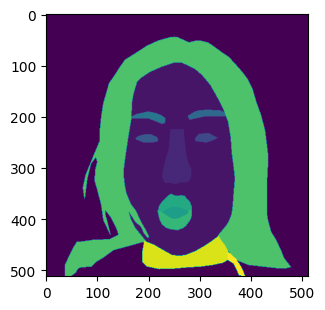

In [93]:
#mask = cv2.imread(os.path.join(root_path, masks_test_path, str(7535) + '.png'))
#mask = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask = Image.open(os.path.join(root_path, masks_test_path, str(7535) + '.png'))
plt.figure(figsize = (3.4, 3.4))
plt.imshow(mask, aspect = 1)

In [94]:
np.array(mask).shape

(512, 512)

In [95]:
def clean_df(df, root_path, imgs_path, masks_path):
  empty_ids = []

  for id in df['id']:
    img_filename = os.path.join(root_path, imgs_path, str(id) + '.jpg')
    mask_filename = os.path.join(root_path, masks_path, str(id) + '.png')

    # print('img_filename: ', img_filename)
    # print('mask_filename: ', mask_filename)

    if not os.path.exists(img_filename):
      #print('No mask for id', id)
      empty_ids.append(id)
      df = df[df['id'] != id] 

    if not os.path.exists(mask_filename):
      #print('No image for id', id)
      empty_ids.append(id)
      df = df[df['id'] != id] 

  return df, empty_ids

In [96]:
df_train_ind, empty_train_ids = clean_df(df_train_ind, root_path, imgs_train_path, masks_train_path)
df_test_ind, empty_test_ids = clean_df(df_test_ind, root_path, imgs_test_path, masks_test_path)

len(df_train_ind)

3722

In [97]:
class Dataset_CelebA():
    def __init__(self, df, transform, root_path, masks_path, imgs_path, augmentation=None):
        self.transform = transform
        self.df = df
        self.root_path = root_path
        self.masks_path = masks_path
        self.imgs_path = imgs_path
        self.augmentation = augmentation


    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        id = self.df[idx] 

        img_filename = os.path.join(self.root_path, self.imgs_path, str(id) + '.jpg')
        #print('img filename: ', img_filename)
        mask_filename = os.path.join(self.root_path, self.masks_path, str(id) + '.png')
        #print('mask filename: ', mask_filename)

        image = self.transform(Image.open(img_filename))
        mask = np.array(Image.open(mask_filename), dtype=np.int64)

        return image, mask


In [98]:
# Check how Dataset works

batch_size = 4
train_dataset_wavs = Dataset_CelebA(list(df_train_ind.iloc[:2]['id']), transform, root_path, masks_color_train_path, imgs_train_path)
train_dataloader_wavs = DataLoader(train_dataset_wavs, batch_size=batch_size, shuffle=True, num_workers=0)
for x, y in train_dataloader_wavs:
  print(x.size(), y.size())

torch.Size([2, 3, 512, 512]) torch.Size([2, 512, 512, 3])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [99]:
df_ind_train_split, df_ind_test_split = train_test_split(df_train_ind, test_size=0.2, random_state=42)

In [100]:
def train(model, device, dataloaders, optimizer, criterion = CrossEntropyLoss(), n_epochs = 5):
  #scaler = torch.cuda.amp.GradScaler()

  since = time.time()
  best_model_wts = copy.deepcopy(model.state_dict())
  check_loss = 10000
  history_train_loss = []
  history_val_loss = []

  for epoch in trange(n_epochs):
    print('Epoch {}/{}'.format(epoch+1, n_epochs))
    print('-' * 10)

    for phase in ['train', 'val']:

      if phase == 'train':
          model.train()  # Set model to training mode
      else:
          model.eval()   # Set model to evaluate mode

      running_loss = 0.0

      # Iterate over data
      for inputs, labels in dataloaders[phase]:
          inputs = inputs.to(device)
          labels = labels.to(device)

          optimizer.zero_grad()


          # forward
          # track history if only in train
          with torch.set_grad_enabled(phase == 'train'):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)

              # backward + optimize only if in training phase
              if phase == 'train':
                  loss.backward()
                  optimizer.step()


          # statistics
          running_loss += loss.item() * inputs.size(0)

      epoch_loss = running_loss / len(dataloaders[phase].dataset)
      if phase == 'train':
        history_train_loss.append(epoch_loss)

      if phase == 'val':
        print('{} Loss: {:.4f}\n'.format(phase, epoch_loss))
        history_val_loss.append(epoch_loss)

      # deep copy the model
      if phase == 'val' and epoch_loss < check_loss:
          check_loss = epoch_loss
          best_model_wts = copy.deepcopy(model.state_dict())

      print()

    torch.save({
      'epoch': epoch,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
  }, 'Resnet50_pretrained_CelebA_checkpoint.pth')

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

  # load best model weights
  model.load_state_dict(best_model_wts)
  torch.save(model.state_dict(), 'best_model_resnet50_CelebA.pth')
  return model 

In [129]:
def test(model, dataloaders, criterion=CrossEntropyLoss(), device=device):

    inputs_list = []
    preds_list = []
    labels_list = []
    print('Testing mode: ')

    model.eval()
    for inputs, labels in tqdm(dataloaders['test']):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)


        inputs_list.extend(inputs)
        labels_list.extend(labels)
        preds_list.extend(preds)
 

    return preds_list, inputs_list, labels_list#, test_dice# , test_iou 

In [120]:
next(iter(dataloaders['test']))

torch.Size([4, 512, 512])

In [102]:
batch_size = 4
model = nn.Sequential(resnet, segmentation_head).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = CrossEntropyLoss()
n_epochs = 5

In [103]:
generator1 = np.random.seed(42)

train_dataset = Dataset_CelebA(list(df_ind_train_split['id']),
                        transform, root_path, masks_train_path, imgs_train_path) #iloc[0:200]
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, generator = generator1)

val_dataset = Dataset_CelebA(list(df_ind_test_split['id']), 
                      transform, root_path, masks_train_path, imgs_train_path) #iloc[0:200]
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, generator = generator1)

test_dataset = Dataset_CelebA(list(df_test_ind['id']), 
                              transform, root_path, masks_test_path, imgs_test_path) #iloc[0:200]
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, generator = generator1)
dataloaders = {"train": train_dataloader, "val": val_dataloader, 'test':test_dataloader}


In [104]:
model = train(model, device, dataloaders, criterion = criterion, 
              optimizer = optimizer, n_epochs = n_epochs)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5
----------

val Loss: 0.6176




 20%|██        | 1/5 [20:56<1:23:46, 1256.64s/it]

Epoch 2/5
----------

val Loss: 0.4215




 40%|████      | 2/5 [23:04<29:38, 592.94s/it]   

Epoch 3/5
----------

val Loss: 0.3026




 60%|██████    | 3/5 [25:13<12:41, 380.71s/it]

Epoch 4/5
----------

val Loss: 0.2428




 80%|████████  | 4/5 [27:21<04:41, 281.03s/it]

Epoch 5/5
----------

val Loss: 0.2152




100%|██████████| 5/5 [29:30<00:00, 354.02s/it]


Training complete in 29m 30s
Testing mode: 


TypeError: ignored

In [130]:
preds, inputs, labels = test(model, dataloaders, criterion=criterion, device=device)

Testing mode: 


  0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 313/313 [00:35<00:00,  8.81it/s]


In [125]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

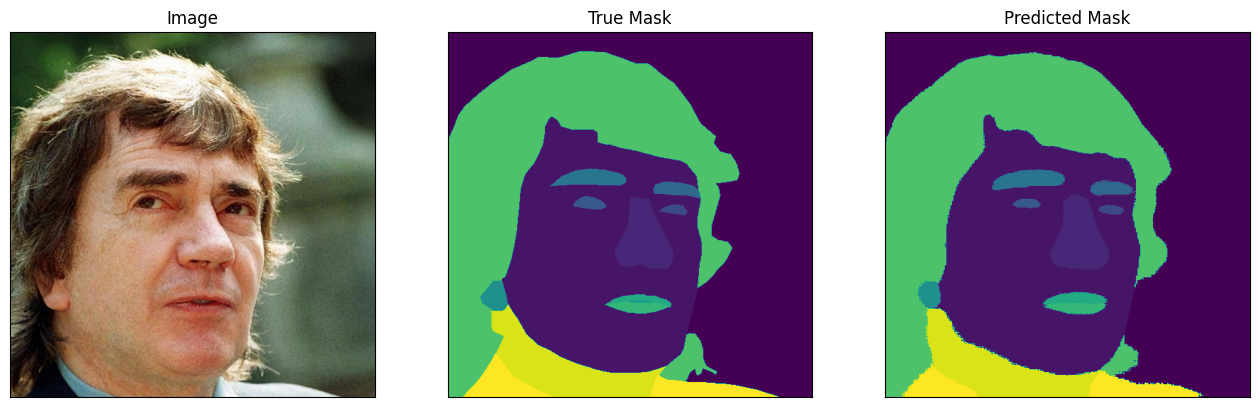

In [138]:
pred1 = preds[1].cpu().detach().numpy()

inv_normalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)
img1 = inv_normalize(inputs[1])
img1 = transforms.ToPILImage()(img1)

label1 = labels[1].cpu().detach().numpy()


pred_1 = Image.fromarray((pred1).astype(np.uint8))
label_1 = Image.fromarray((label1).astype(np.uint8))


visualize(
    image=img1, 
    true_mask=label_1,
    predicted_mask = pred_1
)

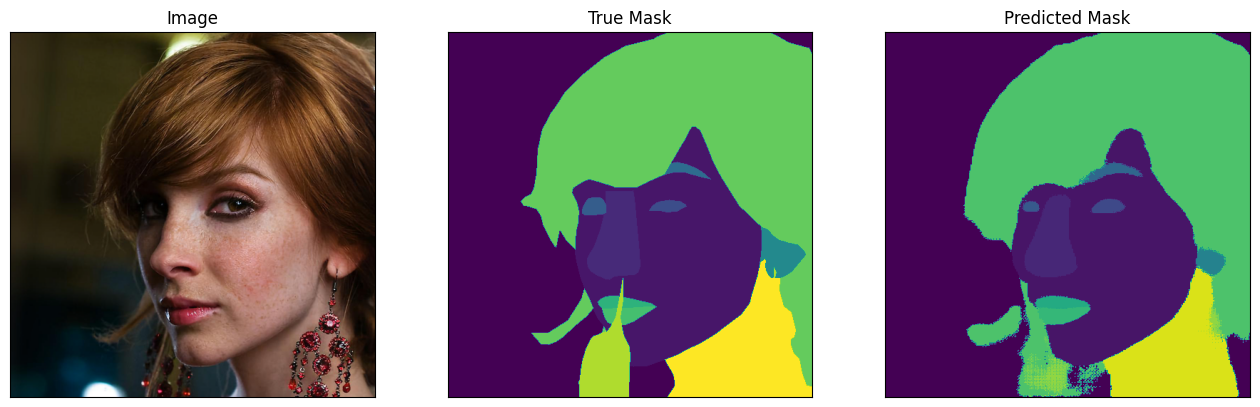

In [140]:
pred115 = preds[115].cpu().detach().numpy()

inv_normalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)
img115 = inv_normalize(inputs[115])
img115 = transforms.ToPILImage()(img115)

label115 = labels[115].cpu().detach().numpy()


pred_115 = Image.fromarray((pred115).astype(np.uint8))
label_115 = Image.fromarray((label115).astype(np.uint8))


visualize(
    image=img115, 
    true_mask=label_115,
    predicted_mask = pred_115)

In [142]:
! pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 10.4 MB/s eta 0:00:00


In [143]:
# Compute Dice metric for the test dataset
from torchmetrics import Dice

dice = Dice(num_classes = 19, average='micro').to(device)
summ = 0
for x, y in zip(preds, labels):
  summ += dice(x.to(device), y.to(device))

dice_average = summ/len(labels)

dice_average

tensor(0.9347, device='cuda:0')

In [146]:
preds[0].size()

torch.Size([512, 512])